In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
male_female = pd.read_csv("male_femal_dataset.csv")

# make columns better
male_female['HD2019.Tribal college'] = male_female['HD2019.Tribal college'].map({'Yes': 'Tribal', 'No': 'Not Tribal', np.nan: 'Not Tribal'})
male_female['hbcu'] = male_female['HD2019.Historically Black College or University']
male_female['tribal'] = male_female['HD2019.Tribal college']
male_female['school_size'] = male_female['HD2019.Institution size category.1']
male_female['urban'] = male_female['HD2019.Degree of urbanization (Urban-centric locale)']

male_female['wage_gap'] = male_female["male_differential"]/male_female['EARN_MALE_NE_MDN_3YR']*100
male_female = male_female[['wage_gap', 'CIPDESC', 'CONTROL', 'INSTNM', 'CREDDESC', 'hbcu', 'tribal', 'school_size', 'urban']] #, 'HD2019.Tribal college']]

male_female.CREDDESC.value_counts()

CREDDESC
Bachelor’s Degree                       5414
Master's Degree                         1832
Associate's Degree                      1183
Undergraduate Certificate or Diploma     889
First Professional Degree                503
Doctoral Degree                          186
Graduate/Professional Certificate         29
Name: count, dtype: int64

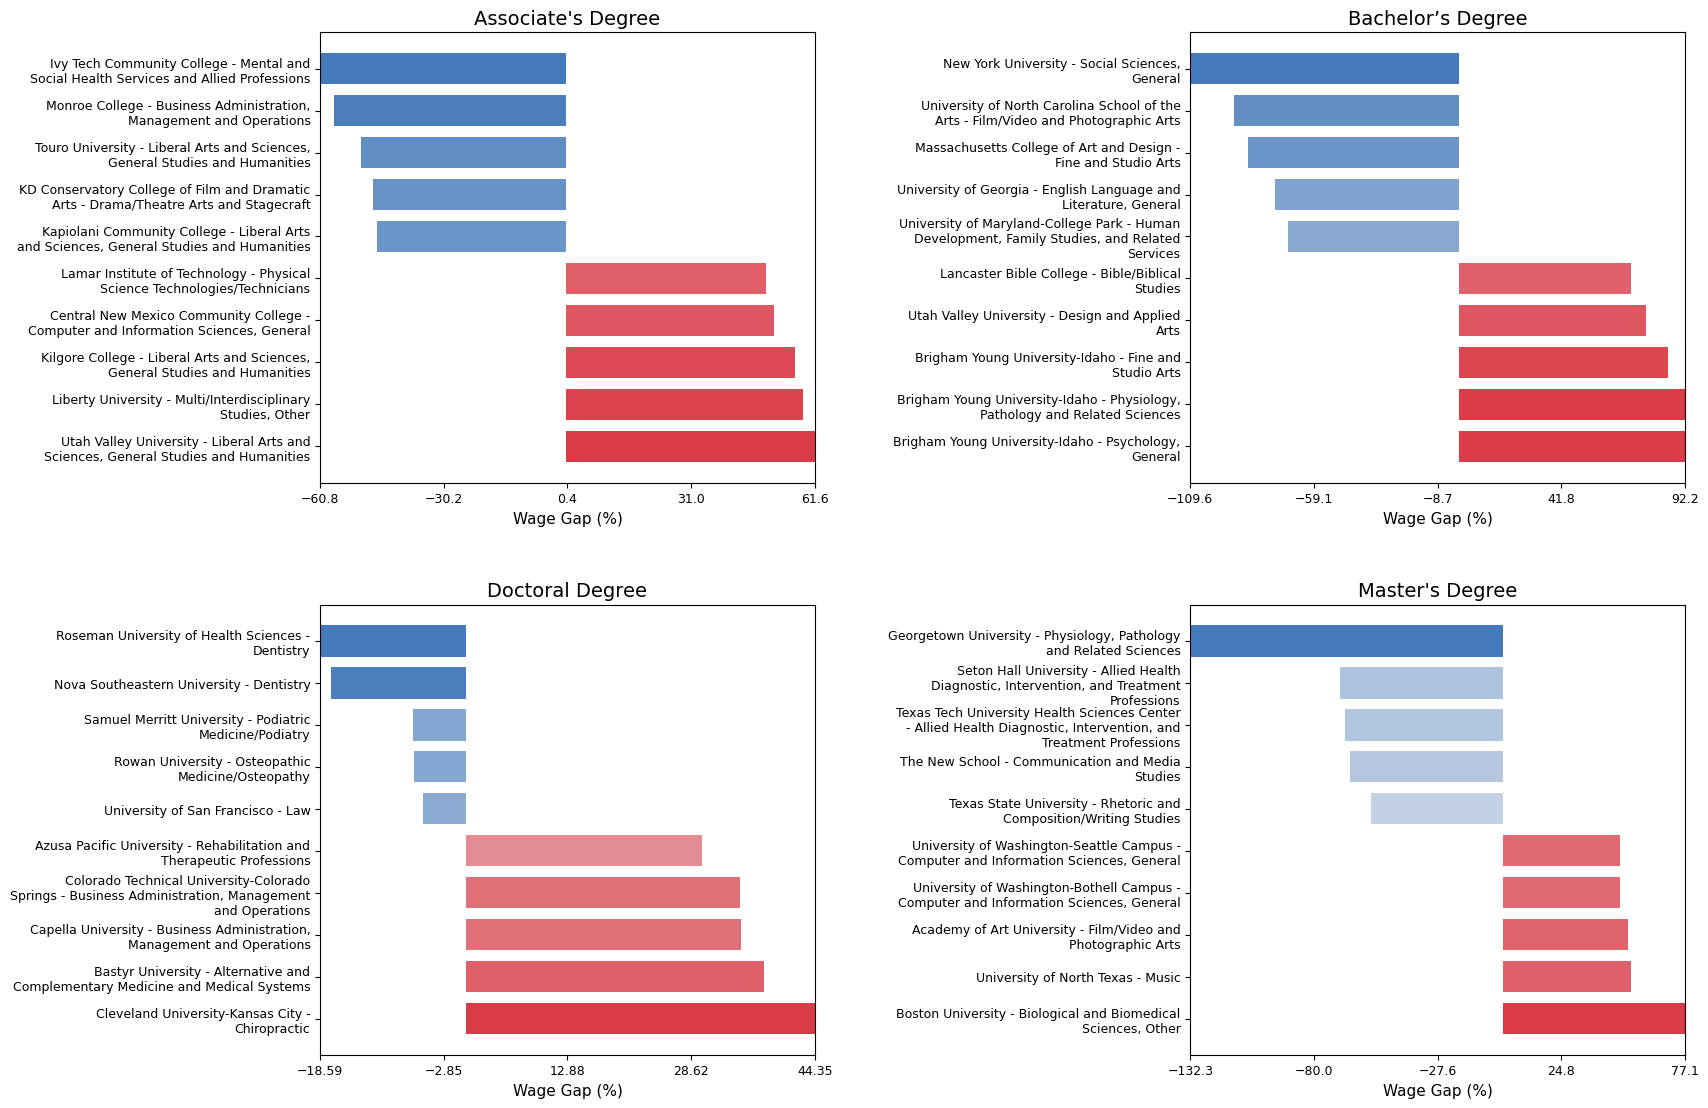

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import matplotlib.gridspec as gridspec

# Wrap long labels for better display
def wrap_label(label, width=45):
    return "\n".join(textwrap.wrap(label.replace(".", ""), width))

# Filter only specific degree types
allowed_degrees = ["Associate's Degree", "Bachelor’s Degree", "Master's Degree", "Doctoral Degree"]
plot_data = male_female[male_female["CREDDESC"].isin(allowed_degrees)].copy()
plot_data["label"] = (plot_data["INSTNM"] + " - " + plot_data["CIPDESC"]).apply(lambda x: wrap_label(x, 45))

creds = sorted(plot_data["CREDDESC"].unique())
n_creds = len(creds)

# Set up 2 columns per row
n_cols = 2
n_rows = int(np.ceil(n_creds / n_cols))

fig = plt.figure(figsize=(18, 6 * n_rows))
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig)

axes = []
for i in range(n_creds):
    row = i // n_cols
    col = i % n_cols
    ax = fig.add_subplot(gs[row, col])
    axes.append(ax)

# Colorblind-friendly diverging palette
cmap = sns.diverging_palette(250, 10, as_cmap=True)  # blue to red, colorblind friendly

# Plot each degree type
for i, cred in enumerate(creds):
    ax = axes[i]
    sub_df = plot_data[plot_data["CREDDESC"] == cred]

    # Get top 5 and bottom 5 wage gaps
    top_bottom = pd.concat([
        sub_df.nlargest(5, "wage_gap"),
        sub_df.nsmallest(5, "wage_gap")
    ])
    top_bottom = top_bottom.sort_values("wage_gap")

    labels = top_bottom["label"].values
    values = top_bottom["wage_gap"].values

    y_positions = np.arange(len(labels)) * 2
    bar_height = 1.5

    norm = plt.Normalize(values.min(), values.max())
    colors = cmap(norm(values))

    ax.barh(y_positions, values, height=bar_height, color=colors, edgecolor='none')
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, fontsize=9)

    ax.set_title(f"{cred}", fontsize=14)
    ax.set_xlabel("Wage Gap (%)", fontsize=11)
    ax.set_ylabel("")
    ax.tick_params(axis='x', labelsize=9)

    x_min, x_max = values.min(), values.max()
    ticks = np.linspace(x_min, x_max, 5)
    ax.set_xticks(ticks)
    ax.set_xlim(x_min, x_max)
    ax.invert_yaxis()

# Hide unused subplots if any
for j in range(len(axes), n_rows * n_cols):
    fig.add_subplot(gs[j // n_cols, j % n_cols]).set_visible(False)

plt.tight_layout(pad=4.0)
plt.show()


In [5]:
# Get row with minimum wage gap
min_row = male_female.loc[male_female["wage_gap"].idxmin()]
# Get row with maximum wage gap
max_row = male_female.loc[male_female["wage_gap"].idxmax()]

# Print results
print("Minimum Wage Gap:")
print(f"{min_row['INSTNM']} - {min_row['CIPDESC']}")
print(f"Wage Gap: {min_row['wage_gap']:.2f}%\n")

print("Maximum Wage Gap:")
print(f"{max_row['INSTNM']} - {max_row['CIPDESC']}")
print(f"Wage Gap: {max_row['wage_gap']:.2f}%")

Minimum Wage Gap:
Texas Barber College - Cosmetology and Related Personal Grooming Services.
Wage Gap: -370.80%

Maximum Wage Gap:
Brigham Young University-Idaho - Psychology, General.
Wage Gap: 92.23%


/var/folders/2h/f906sd_j74jc6_9x83gsf8280000gn/T/ipykernel_2403/4248451828.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


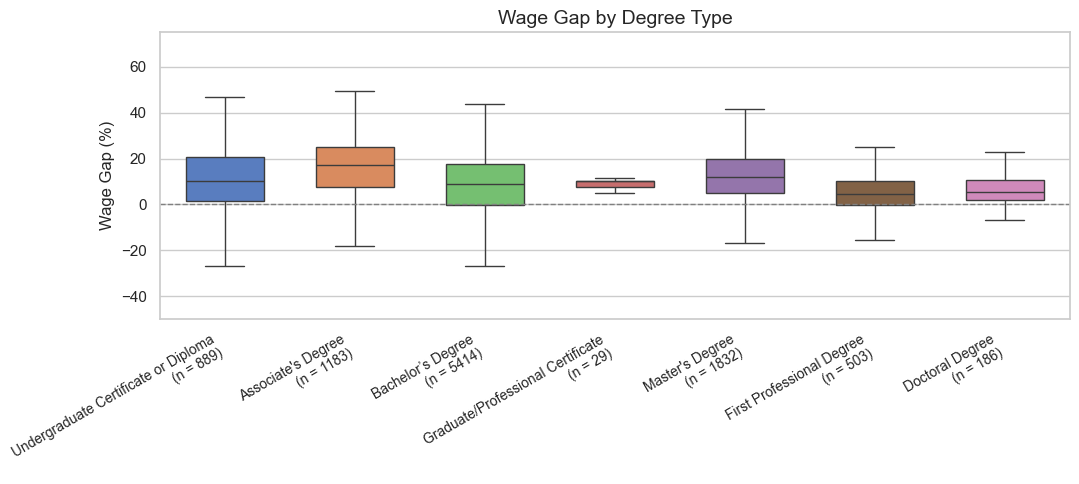

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid", context="notebook")
df = male_female
# Custom degree order (from lowest to highest level)
degree_order = [
    "Undergraduate Certificate or Diploma",
    "Associate's Degree",
    "Bachelor’s Degree",
    "Graduate/Professional Certificate",
    "Master's Degree",
    "First Professional Degree",
    "Doctoral Degree"
]

# Create labeled categories with counts
degree_counts = df["CREDDESC"].value_counts()
labels_with_counts = [
    f"{deg}\n(n = {degree_counts.get(deg, 0)})" for deg in degree_order
]

# Map original degrees to the label with count
label_map = dict(zip(degree_order, labels_with_counts))
df["degree_label"] = df["CREDDESC"].map(label_map)

# Create boxplot
plt.figure(figsize=(11, 5))
sns.boxplot(
    data=df,
    x="degree_label",
    y="wage_gap",
    order=labels_with_counts,
    palette="muted",
    width=0.6,
    showfliers=False
)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.title("Wage Gap by Degree Type", fontsize=14)
plt.ylabel("Wage Gap (%)", fontsize=12)
plt.xlabel("")
plt.xticks(rotation=30, ha="right", fontsize=10)

plt.ylim(-50, 75)
plt.tight_layout()
plt.show()


/var/folders/2h/f906sd_j74jc6_9x83gsf8280000gn/T/ipykernel_11587/4160242583.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/2h/f906sd_j74jc6_9x83gsf8280000gn/T/ipykernel_11587/4160242583.py:28: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(


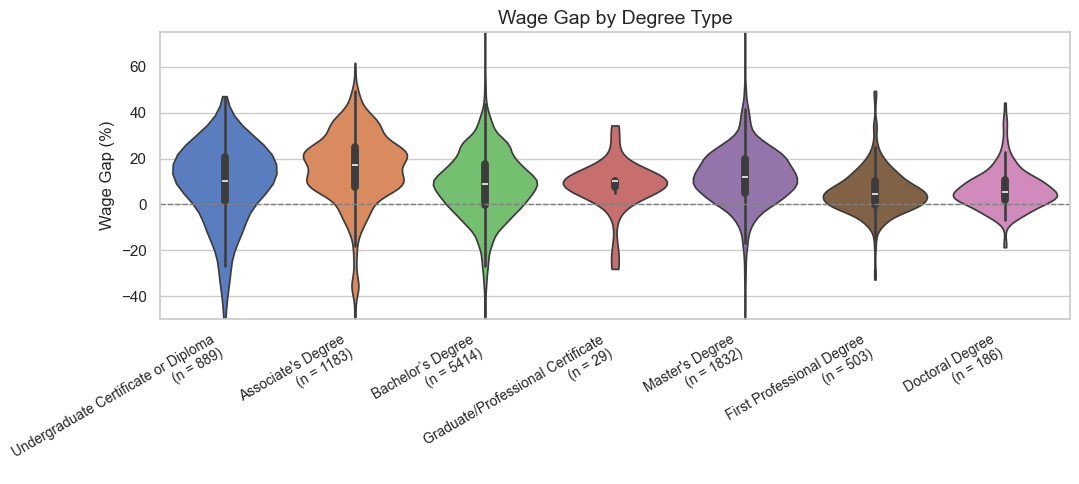

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df = male_female
# Set style
sns.set(style="whitegrid", context="notebook")

# Degree order (from lowest to highest)
degree_order = [
    "Undergraduate Certificate or Diploma",
    "Associate's Degree",
    "Bachelor’s Degree",
    "Graduate/Professional Certificate",
    "Master's Degree",
    "First Professional Degree",
    "Doctoral Degree"
]

# Degree counts and formatted labels
degree_counts = df["CREDDESC"].value_counts()
labels_with_counts = [
    f"{deg}\n(n = {degree_counts.get(deg, 0)})" for deg in degree_order
]
label_map = dict(zip(degree_order, labels_with_counts))
df["degree_label"] = df["CREDDESC"].map(label_map)

# Plot
plt.figure(figsize=(11, 5))
sns.violinplot(
    data=df,
    x="degree_label",
    y="wage_gap",
    order=labels_with_counts,
    palette="muted",
    cut=0,
    inner="box",  # Adds boxplot inside the violin
    scale="count"  # Width of violins reflects sample size
)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Wage Gap by Degree Type", fontsize=14)
plt.ylabel("Wage Gap (%)", fontsize=12)
plt.xlabel("")
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.ylim(-50, 75)
plt.tight_layout()
plt.show()


In [ ]:
male_female[male_female['INSTNM'] == "University of Utah"]

,wage_gap,CIPDESC,CONTROL,INSTNM,CREDDESC,hbcu,tribal,school_size,urban
6715,5.172210,Communication and Media Studies.,Public,University of Utah,Bachelor’s Degree,No,Not Tribal,"20,000 and above",City: Midsize
6716,10.165423,Law.,Public,University of Utah,First Professional Degree,No,Not Tribal,"20,000 and above",City: Midsize
6717,17.125142,"English Language and Literature, General.",Public,University of Utah,Bachelor’s Degree,No,Not Tribal,"20,000 and above",City: Midsize
6718,11.502271,International/Global Studies.,Public,University of Utah,Bachelor’s Degree,No,Not Tribal,"20,000 and above",City: Midsize
6719,2.428542,Health and Physical Education/Fitness.,Public,University of Utah,Bachelor’s Degree,No,Not Tribal,"20,000 and above",City: Midsize
6720,8.110063,"Psychology, General.",Public,University of Utah,Bachelor’s Degree,No,Not Tribal,"20,000 and above",City: Midsize
6721,18.156883,Social Work.,Public,University of Utah,Master's Degree,No,Not Tribal,"20,000 and above",City: Midsize
6722,18.347673,Economics.,Public,University of Utah,Bachelor’s Degree,No,Not Tribal,"20,000 and above",City: Midsize
6723,-6.840626,Sociology.,Public,University of Utah,Bachelor’s Degree,No,Not Tribal,"20,000 and above",City: Midsize
6724,-3.333544,Medicine.,Public,University of Utah,First Professional Degree,No,Not Tribal,"20,000 and above",City: Midsize
